`Air Passengers`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
import pmdarima as pm # Auto ARIMA 모델

In [31]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
ap = pd.read_csv(url)
ap.drop('Month', axis = 1, inplace = True)
print(ap.head())

   Passengers
0         112
1         118
2         132
3         129
4         121


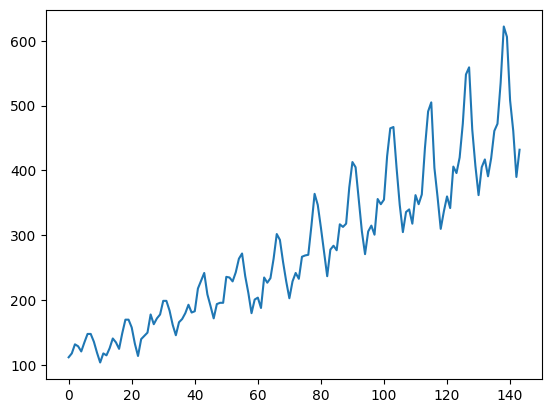

In [32]:
# 데이터 확인하기
plt.plot(ap)
plt.show()

In [33]:
# 분산 일정하게 만들기
ap_log = np.log(ap)

[]

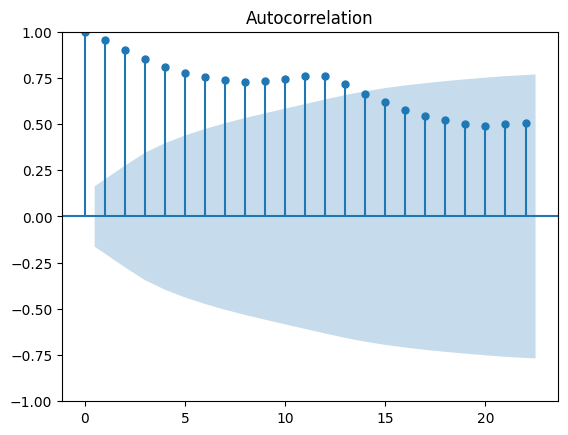

In [34]:
plot_acf(ap_log)
plt.plot()

[]

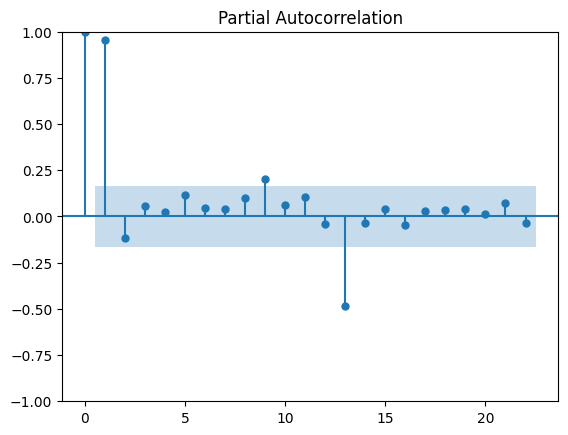

In [35]:
plot_pacf(ap_log)
plt.plot()

In [37]:
train_size = int(len(ap) * 0.8)

ap_log_train = ap_log[:train_size]
ap_log_test = ap_log[train_size:]

In [ ]:
# AutoARIMA
# auto_arima 함수에는 정상성(stationarity)이 확보되지 않은 원본 시계열 데이터를 바로 주어도 됨
# 하지만, 안정적인 예측을 위해서는 로그 변환 후 차분을 통해 정상성을 확보하는 것이 좋음

import pmdarima as pm # Auto ARIMA 모델

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# seasonal = True, max_D(계절차분) = 12
model = pm.AutoARIMA( start_p=1, start_q=1,
                      max_p=3, max_q=3,
                      seasonal=True,
                      m=12,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
res = model.fit(ap_log_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-372.370, Time=1.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.03 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-378.245, Time=0.95 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-350.429, Time=0.20 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-376.304, Time=3.68 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-370.348, Time=1.56 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-374.596, Time=3.19 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-376.945, Time=0.74 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-377.696, Time=1.25 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-376.915, Time=1.65 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-292.202, Time=0.44 sec
 ARIMA(0,0,2)(0,1,1

In [51]:
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  115
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 194.477
Date:                              Mon, 26 May 2025   AIC                           -378.953
Time:                                      19:31:14   BIC                           -365.780
Sample:                                           0   HQIC                          -373.618
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0239      0.011      2.187      0.029       0.002       0.045
ar.L1          0.61

In [52]:
# confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_log_test.shape[0], return_conf_int=True)

# 아래의 코드 결과값을 서로 비교 분석해봅시다.
print(preds.shape)
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))

(29,)
<class 'pandas.core.series.Series'>
--------------------------------------------------------------------------------
29
<class 'int'>


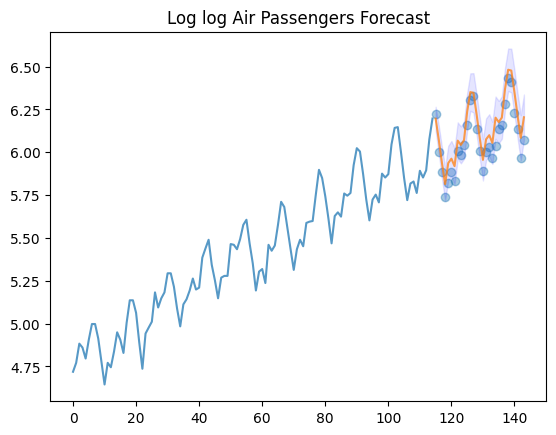

In [ ]:
# 예측 성능을 시각화합니다.
# 0. train과 test data를 축(axis)으로 만들었습니다.
# 1. x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화 합니다.
# 2. 1번 그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성됩니다.
# 3. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성합니다.
# 4. 2, 3번의 분포에 해당하는 구간을 채워 그래프로 나타냈습니다.


x_axis = np.arange(ap_log_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성합니다.
plt.plot(x_axis[:ap_log_train.shape[0]],ap_log_train, alpha=0.75) # 1
plt.plot(x_axis[ap_log_train.shape[0]:], preds, alpha=0.75) # 2
plt.scatter(x_axis[ap_log_train.shape[0]:],ap_log_test,
            alpha=0.4, marker='o')  # 3 기존 test data는 scatter
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 4
plt.title("Log log Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

## S&P

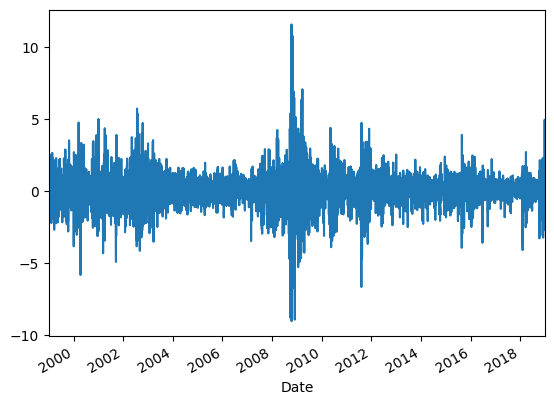

In [ ]:
# ⑦-1 : 데이터 및 라이브러리 불러오기
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러옵니다.


# ⑦-2 : 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) # start date
en = dt.datetime(2022, 1, 1) # end date
data = arch.data.sp500.load() # s&p 500 데이터 불러오기
market = data["Adj Close"] # 종가만 활용
# 퍼센트 변화율(percentage change)을 계산 # 첫 번째 값은 이전 값이 없으므로 NaN. dropna()를 사용하여 NaN 값을 제거
returns = 100 * market.pct_change().dropna() # return값으로 변환 
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한
plt.show()